# Training Unsupervised Models
## 04_unsupervised_model_learning

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 28.09.2025   | Adrienne | Update | Creating models |
| 05.10.2025 | Adrienne | Update | Created baseline model with KMeans |
| 07.10.2025 | Adrienne | Update | Added code for wordcloud visualization |
| 12.10.2025 | Adrienne | Update | Finshing modeling using TF-IDF encoded data |
| 14.10.2025 | Adrienne | Update | Finished DBSCAN and Gaussian |

# Content

* [Introduction](#introduction)

In [763]:
import pandas as pd
import numpy as np

# train test split
from sklearn.model_selection import train_test_split

# dimensionality reduction methods
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.manifold import TSNE

#unsupervised learning methods
# Feature agglomeration uses agglomerative(or hierarchical) clustering to group similar features, so it has its own dimensionality reduction technique
from sklearn.cluster import KMeans, AgglomerativeClustering, FeatureAgglomeration, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

# model selection
from sklearn.model_selection import GridSearchCV

# model scores
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score
import setuptools
from yellowbrick.cluster import SilhouetteVisualizer

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image


## Load Data

In [762]:
# readin in patient level file label encoded
path = "../data/clean"
df = pd.read_pickle(f"{path}/patient_level_features.pkl")

In [764]:
df.drop('total_value',axis = 1, inplace=True)
df.head()

,gender,age,number_of_claims,preventative_care_ind,G9857,G9708,S0605,G0153,G0464,G0155,...,G0157,HCPCS_level_1,HCPCS_level_2,National_Codes_Established_for_State_Medicaid_Agencies,Evaluation_and_Management_(E/M)_Codes_,Temporary_Codes,Temporary_National_Codes_(Non-Medicare),Procedures/Professional_Services,Alcohol_and_Drug_Abuse_Treatment,Outpatient_PPS
0,0,79.0,18,1,0.0,0.0,0.0,0.0,0.279341,0.0,...,0.0,0.665558,0.746346,0.0,0.665558,0.0,0.0,0.746346,0.0,0.0
1,1,75.0,17,1,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.892770,0.450512,0.0,0.892770,0.0,0.0,0.450512,0.0,0.0
2,0,77.0,29,1,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.938776,0.344529,0.0,0.938776,0.0,0.0,0.344529,0.0,0.0
3,0,78.0,24,1,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.855392,0.517980,0.0,0.855392,0.0,0.0,0.517980,0.0,0.0
4,1,80.0,19,1,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.313617,0.949550,0.0,0.313617,0.0,0.0,0.949550,0.0,0.0


## Introduction - Model Development

We will create a baseline model using the label encoded patient level file.  Variations on the model will be added and then performance compared.  Initially, we encoded the data using labels, but when running the first Kmeans model, we realized that the missings created by that feature encoding method was not surprisingly giving very poor results.  We then switched to TD-IDF encoding and got much better and useful results.

### Creating Helper Functions

In [765]:
def standardize_features(dataset):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(dataset)
    return X_scaled

In [766]:
def dim_red_PCA(n_components, dataset):
    
    pca = PCA(n_components = n_components, random_state = 42)
    X_pca = pca.fit_transform(dataset)

# Calculate the explained variance ratio
    explained_variance_ = pca.explained_variance_
    explained_variance_ratio_ = pca.explained_variance_ratio_
    c_sum = np.cumsum(explained_variance_ratio_) 
    pc_components = np.arange(pca.n_components_) + 1
    c_sum_df = pd.DataFrame(zip(pc_components, c_sum), columns=['Principal Component', 'Cummulative Explained Variance'])
    print(c_sum_df)
    
    return pca, X_pca, explained_variance_, c_sum_df

In [767]:
def create_scree_plot(pca, explained_variance_, method ):
    eigenvalues = pca.explained_variance_
    prop_var = eigenvalues / np.sum(eigenvalues)
    if method == 'pca':
        pc_numbers = np.arange(pca.n_components_) + 1
    elif method == 'lsa':
        pc_numbers = np.arange(pca.components_) + 1
    
    fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(10, 4))
    
    #plt.figure(figsize=(5, 4)) 
    ax1.plot(
             pc_numbers, 
             eigenvalues, 
            'b.-')
    
    ax1.axhline(y=1, color='r', linestyle='--')
    ax1.set_title('Figure 1: Scree Plot for Eigenvalues', fontsize=8)
    ax1.set_ylabel('Eigenvalues', fontsize=8)
    ax1.set_xlabel('Principal Component', fontsize=8)
    
#     ax1.set_xticks(fontsize=6)
#     ax1.set_yticks(fontsize=6)

    ax2.plot(
             pc_numbers, 
             prop_var, 
            'b.-')
    
    ax2.set_title('Figure 2: Scree Plot for Proportion of Variance Explained', fontsize=8)
    ax2.set_ylabel('Proportion of Variance Explained', fontsize=8)
    ax2.set_xlabel('Principal Component', fontsize=8)

    plt.show()
    
    return None 

In [768]:
def feature_importance(pca, dataset):
    # number of components
    n_pcs= pca.components_.shape[0]

    # get the index of the most important feature on EACH component i.e. largest absolute value
    # using LIST COMPREHENSION HERE
    most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

    initial_feature_names = dataset.columns

    # get the names
    most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

    # using LIST COMPREHENSION HERE AGAIN
    dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}
   
    return dic

In [769]:
def create_cluster_plot(labels, n_clusters, X_pca, model, axis, model_type):
      
    if model_type == 'dbscan':
            unique_labels = set(labels)
            n_clusters = len([l for l in unique_labels if l != -1])
             
    colors = cm.jet( (labels.astype(float) * 1.5 ) / (n_clusters))
    
    axis.scatter(
            X_pca[:, 0], X_pca[:, 1], 
            marker=".", 
            s=30, 
            lw=0, 
            alpha=0.7, 
            color = colors,
            edgecolor="k"
        )

    # Labeling the clusters
    if model_type == 'km':
        centers = model.cluster_centers_
    elif model_type == 'gmm':
        centers = model.means_
    elif model_type == 'dbscan':
        centers = []
        for label in unique_labels:
            if label == -1:
                continue  # skip noise
            cluster_points = X_pca[labels == label]
            centers.append(list(cluster_points.mean(axis=0)))
            
    # Draw white circles at cluster centers
    axis.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=100,
            edgecolor="k",
        )

    for i, c in enumerate(centers):
        cl = i * 1.5
        axis.scatter(c[0], c[1], 
                marker="$%d$" % i, 
                alpha=1, s=20, 
                color = cm.jet( (cl ) / (n_clusters)))
        axis.set_title("K-Means Clustering Results")
        axis.set_xlabel("1st Feature space")
        axis.set_ylabel("2nd Feature space")
        axis.grid(False)
        
    plt.rcParams['axes.titlesize'] = 8
    plt.rcParams['axes.labelsize'] = 8
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

    plt.show()
    return None

In [770]:
def calculate_silhouette_score(X_pca, labels, metric, model_type):
    # works for all sklearn unsupervised model evaluation metrics with DBSCAN
        # Filter out noise for silhouette
    if model_type == 'dbscan':
        mask = labels != -1
        n_clusters = len(set(labels[mask]))

        if n_clusters > 1:
            score = silhouette_score(X_pca[mask], labels[mask], metric=metric)
    else:
        score = silhouette_score(X_pca, labels, metric= metric)
    #print(f'Silhouette Score using {metric} : %.3f {% score}')
    #print(f'Silhouette Score using {metric}: {score}')
    
    return score

In [771]:
def create_elbow_plot(cluster_range_start, cluster_range_end, X_pca):
    sse = []
    for i in range(cluster_range_start, cluster_range_end):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=5, random_state=42)
        kmeans.fit(X_pca)
        sse.append(kmeans.inertia_)

    plt.figure(figsize=(3, 3)) 
    plt.plot(range(cluster_range_start, cluster_range_end), sse)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

    plt.show()
    return None

### Baseline Model - KMeans
Steps: 
- standardize features
- reduce features using PCA
- use Scree plot to find optimal number of components
- create KMeans model
- find optimal number of clusters using Silhouette and Elbow methods
- examine most important feature by principal component
- create graph of clusters with first two principal components
- optimize any model inputs

## KMeans using TF-IDF Encoded Data

Standardizing Features

In [772]:
# Standardize the features
X_scaled = standardize_features(df)

Dimensionality Reduction using Principal Component Analysis

In [773]:
# Perform PCA
pca, X_pca, explained_variance_, c_sum_df = dim_red_PCA(14, X_scaled)

    Principal Component  Cummulative Explained Variance
0                     1                        0.242001
1                     2                        0.351781
2                     3                        0.409579
3                     4                        0.465137
4                     5                        0.503952
5                     6                        0.538154
6                     7                        0.570440
7                     8                        0.600908
8                     9                        0.630056
9                    10                        0.657094
10                   11                        0.678230
11                   12                        0.697141
12                   13                        0.715623
13                   14                        0.733910


Scree Plot - to Analyze Optimal PCA Components

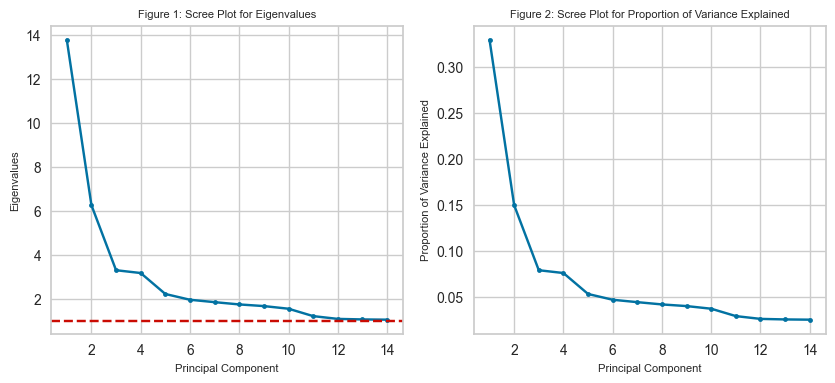

In [774]:
create_scree_plot(pca, explained_variance_, 'pca')

In [775]:
# Final PCA
pca, X_pca, explained_variance_, c_sum_df = dim_red_PCA(5, X_scaled)

   Principal Component  Cummulative Explained Variance
0                    1                        0.242001
1                    2                        0.351781
2                    3                        0.409579
3                    4                        0.465137
4                    5                        0.503952


In [776]:
pca, X_pca, explained_variance_, c_sum_df = dim_red_PCA(11, X_scaled)

    Principal Component  Cummulative Explained Variance
0                     1                        0.242001
1                     2                        0.351781
2                     3                        0.409579
3                     4                        0.465137
4                     5                        0.503952
5                     6                        0.538154
6                     7                        0.570440
7                     8                        0.600908
8                     9                        0.630056
9                    10                        0.657094
10                   11                        0.678230


In [777]:
# Step 3: Feature importance from PCA
dic = feature_importance(pca, df)
dic

{'PC1': 'HCPCS_level_1',
 'PC2': 'S9126',
 'PC3': 'G8946',
 'PC4': 'H2000',
 'PC5': 'G0444',
 'PC6': 'T1502',
 'PC7': 'S9473',
 'PC8': 'S0605',
 'PC9': 'G0102',
 'PC10': 'C8928',
 'PC11': 'G9708'}

In [778]:
# kmeans code
kmeans = KMeans(init = 'k-means++', n_clusters=9, n_init= 5, random_state = 42) 
km = kmeans.fit(X_pca) 
labels = km.predict(X_pca)

# add cluster results to dataset
df['cluster'] = labels

In [779]:
# quick look at cluster values
vals = df['cluster'].value_counts(normalize=True) * 100
pd.DataFrame({
  'cluster': vals
}).head(12)

,cluster
cluster,
1,27.541235
0,23.973916
8,23.858842
2,11.507480
3,7.825086
4,2.148063
6,1.380898
5,1.074031
7,0.690449


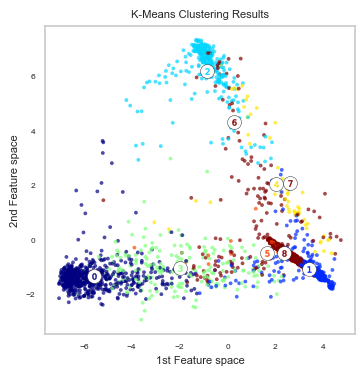

In [780]:
fig, ax = plt.subplots(figsize=(4, 4))
create_cluster_plot(labels, 9, X_pca, km, ax, model_type = 'km')

Create Silhouette Plot

For n_clusters = 6 The average silhouette_score using euclidean is : 0.5774154651091141
For n_clusters = 6 The average silhouette_score using cosine is : 0.6804116779444194


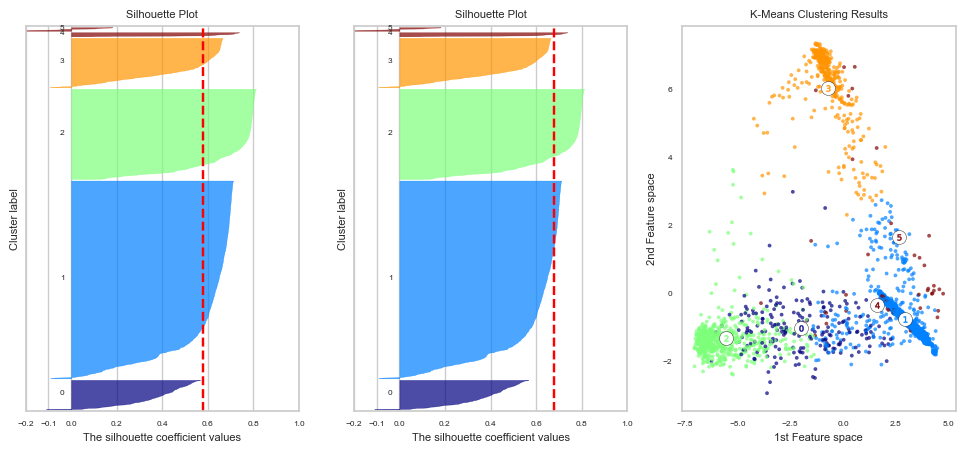

For n_clusters = 7 The average silhouette_score using euclidean is : 0.4433696019755337
For n_clusters = 7 The average silhouette_score using cosine is : 0.6398488171878788


<Figure size 800x550 with 0 Axes>

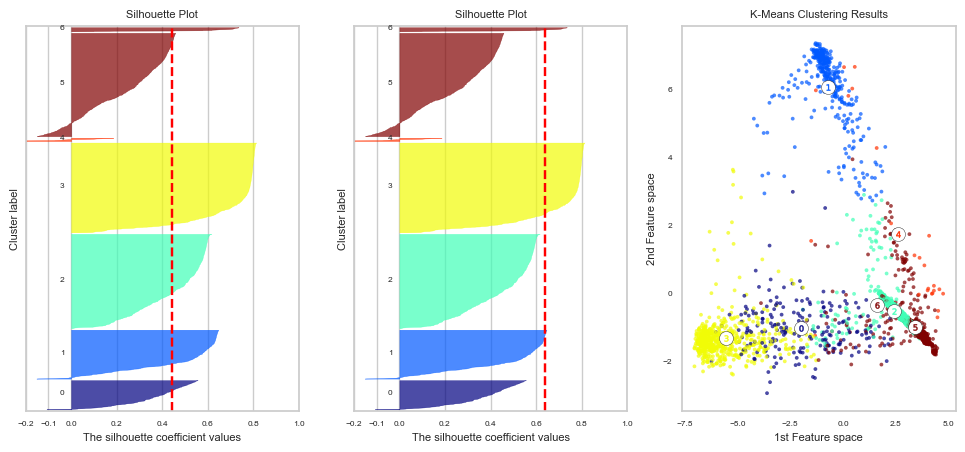

For n_clusters = 8 The average silhouette_score using euclidean is : 0.6119550520613956
For n_clusters = 8 The average silhouette_score using cosine is : 0.7029424243772362


<Figure size 800x550 with 0 Axes>

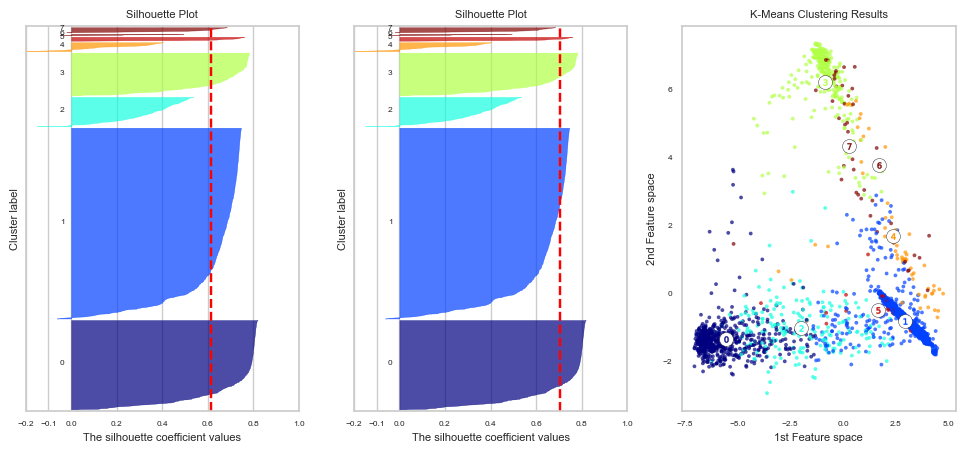

For n_clusters = 9 The average silhouette_score using euclidean is : 0.4860598785108758
For n_clusters = 9 The average silhouette_score using cosine is : 0.6753821909033749


<Figure size 800x550 with 0 Axes>

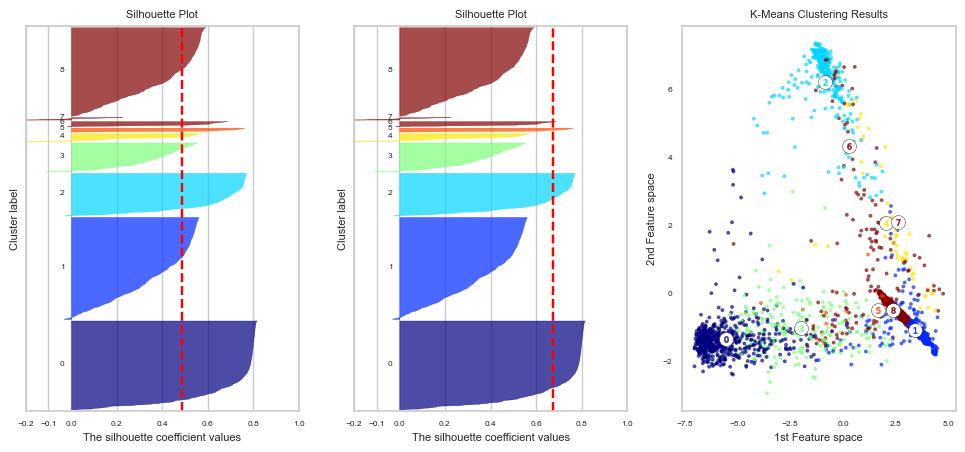

For n_clusters = 10 The average silhouette_score using euclidean is : 0.48906628728514123
For n_clusters = 10 The average silhouette_score using cosine is : 0.6744743524122212


<Figure size 800x550 with 0 Axes>

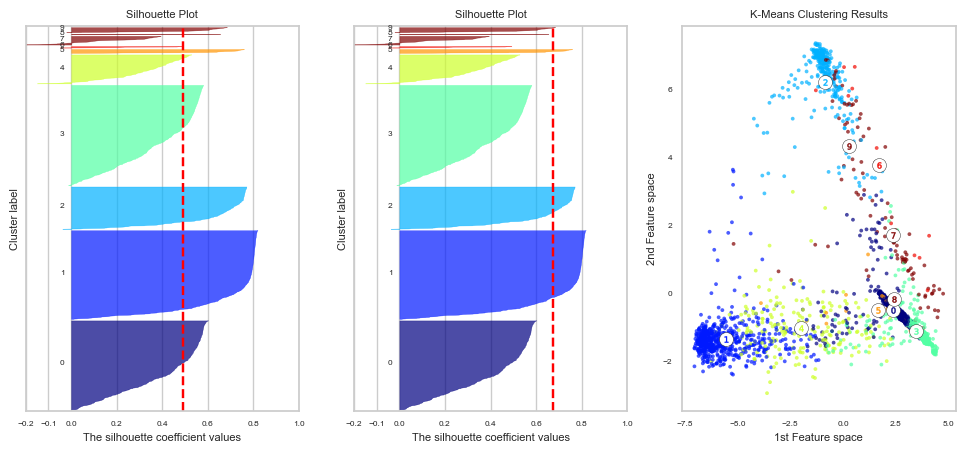

<Figure size 800x550 with 0 Axes>

In [781]:

range_n_clusters = [6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(12, 5))
    
    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots
    ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    km = KMeans(init = 'k-means++', n_clusters=n_clusters, n_init = 5, random_state=42)
    labels = km.fit_predict(X_pca)

    #silhouette_avg = silhouette_score(X_pca, cluster_labels)
    silhouette_avg = calculate_silhouette_score(X_pca, labels, 'euclidean', 'km')
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score using euclidean is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cl = float(i) * 1.5
        color = cm.jet( cl / (n_clusters))
        #color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize = 6)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette Plot")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.tick_params(axis='y', labelsize=6)
    ax1.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.tick_params(axis='x', labelsize=6)



# The 1st subplot is the silhouette plot
    ax2.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots
    ax2.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    km = KMeans(init = 'k-means++', n_clusters=n_clusters, n_init = 5, random_state=42)
    labels = km.fit_predict(X_pca)

    #silhouette_avg = silhouette_score(X_pca, cluster_labels)
    silhouette_avg = calculate_silhouette_score(X_pca, labels, 'cosine', 'km')
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score using cosine is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cl = float(i) * 1.5
        color = cm.jet( cl / (n_clusters))
        #color = cm.nipy_spectral(float(i) / n_clusters)
        ax2.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize = 6)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax2.set_title("Silhouette Plot")
    ax2.set_xlabel("The silhouette coefficient values")
    ax2.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax2.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax2.set_yticks([])  # Clear the yaxis labels / ticks
    ax2.tick_params(axis='y', labelsize=6)
    ax2.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax2.tick_params(axis='x', labelsize=6)


    # 2nd Plot showing the actual clusters formed
    create_cluster_plot(labels, n_clusters, X_pca, km, ax3, model_type = 'km')

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=8,
        fontweight="bold",
    )

plt.show()

Elbow Method

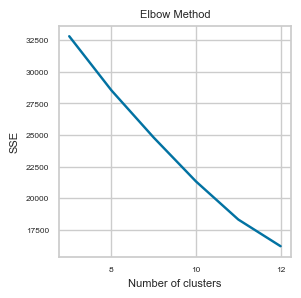

In [782]:
create_elbow_plot(7, 13, X_pca)

In [783]:
# kmeans code
kmeans = KMeans(init = 'k-means++', n_clusters=8, n_init= 5, random_state = 42) 
km = kmeans.fit(X_pca) 
labels = km.predict(X_pca)

# add cluster results to dataset
df['cluster'] = labels

In [784]:
# works for all sklearn unsupervised model evaluation metrics with DBSCAN
print(f"silhouette score using euclidean: {calculate_silhouette_score(X_pca, labels, 'euclidean', 'km')}")
print(f"silhouette score using cosine: {calculate_silhouette_score(X_pca, labels, 'cosine', 'km')}")

silhouette score using euclidean: 0.6119550520613956
silhouette score using cosine: 0.7029424243772362


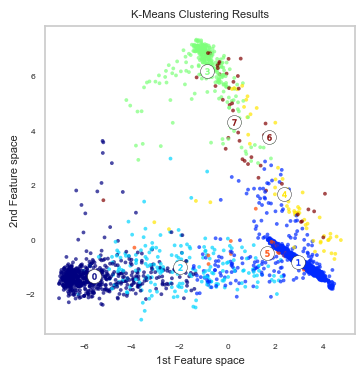

In [785]:
fig, ax = plt.subplots(figsize=(4, 4))
create_cluster_plot(labels, 9, X_pca, km, ax, model_type = 'km')

In [786]:
# quick look at cluster values
vals = df['cluster'].value_counts(normalize=True) * 100
pd.DataFrame({
  'cluster': vals
}).head(12)

,cluster
cluster,
1,51.285002
0,24.012275
3,11.507480
2,7.901803
4,2.416571
7,1.380898
5,1.074031
6,0.421941


In [787]:
# Step 3: Feature importance from PCA
dic = feature_importance(pca, df)
dic

{'PC1': 'HCPCS_level_1',
 'PC2': 'S9126',
 'PC3': 'G8946',
 'PC4': 'H2000',
 'PC5': 'G0444',
 'PC6': 'T1502',
 'PC7': 'S9473',
 'PC8': 'S0605',
 'PC9': 'G0102',
 'PC10': 'C8928',
 'PC11': 'G9708'}

In [788]:
# save dataset
df.to_pickle(f"{path}/df_unsupervised_final.pkl")

### DBSCAN

In [791]:
n = pca.n_components_
neighbors = NearestNeighbors(n_neighbors=n)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)

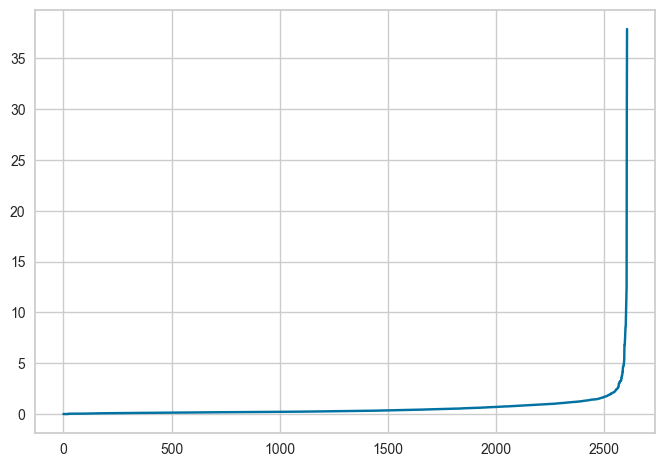

In [792]:
distances_el = np.sort(distances, axis=0)
distances_el = distances_el[:,1]
plt.plot(distances_el)

In [685]:
distances_el = np.sort(distances, axis=0)
distances_el = distances_el[:,1]
distances_el

array([ 0.        ,  0.        ,  0.        , ..., 28.21989141,
       33.25089435, 38.30681307], shape=(2607,))

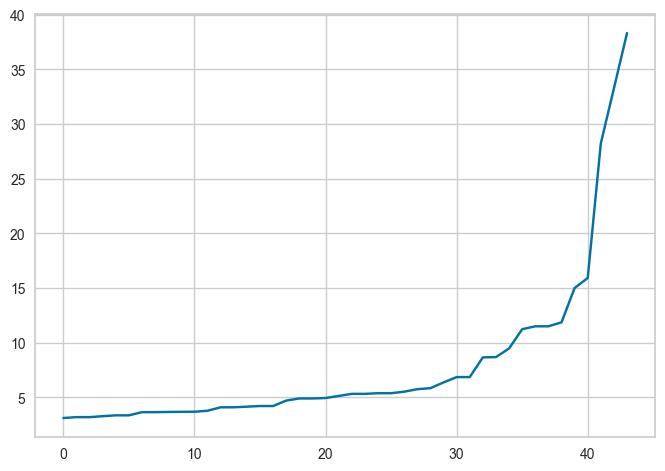

In [681]:
distances_el = np.sort(distances, axis=0)
distances_el = distances_el[:,1]
distances_el = distances_el[distances_el > 3]
plt.plot(distances_el)

In [793]:
param_grid = {'eps': [0.75, 1, 1.25, 1.5], 'min_samples': [5, 10, 15]} # easily add another parameter to this structure

for eps in param_grid['eps']:
    for min_sam in param_grid['min_samples']:
        dbscan = DBSCAN(eps=eps, min_samples=min_sam, metric='euclidean')
        labels = dbscan.fit_predict(X_pca)
        df['cluster'] = labels
        print(f'silhouette euclidean for eps {eps} and min_sample {min_sam}: {calculate_silhouette_score(X_pca, labels, 'euclidean', 'dbscan')}')
        print(f'silhouette cosine for eps {eps} and min_sample {min_sam}: {calculate_silhouette_score(X_pca, labels, 'cosine', 'dbscan')}')

silhouette euclidean for eps 0.75 and min_sample 5: 0.4469005379649898
silhouette cosine for eps 0.75 and min_sample 5: 0.5064158757563797
silhouette euclidean for eps 0.75 and min_sample 10: 0.6926423996877238
silhouette cosine for eps 0.75 and min_sample 10: 0.6347360520016123
silhouette euclidean for eps 0.75 and min_sample 15: 0.5877748466956818
silhouette cosine for eps 0.75 and min_sample 15: 0.5296930099198981
silhouette euclidean for eps 1 and min_sample 5: -0.060595231286652826
silhouette cosine for eps 1 and min_sample 5: -0.28442581911869047
silhouette euclidean for eps 1 and min_sample 10: 0.6655293438316925
silhouette cosine for eps 1 and min_sample 10: 0.6277377939798356
silhouette euclidean for eps 1 and min_sample 15: 0.6770065261685376
silhouette cosine for eps 1 and min_sample 15: 0.6297337691597436
silhouette euclidean for eps 1.25 and min_sample 5: -0.11564205563137077
silhouette cosine for eps 1.25 and min_sample 5: -0.47484513911882836
silhouette euclidean for eps

In [794]:
dbscan = DBSCAN(eps = 0.75, min_samples=10, metric='euclidean')
labels = dbscan.fit_predict(X_pca)
df['cluster'] = labels

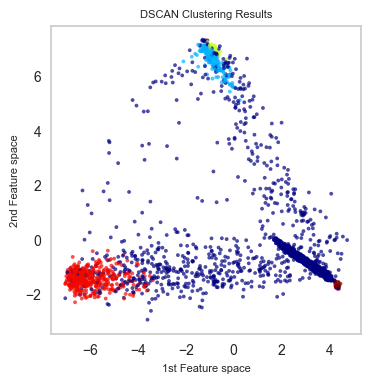

In [795]:
unique_labels = set(labels)
n_clusters = len([l for l in unique_labels if l != -1])
             
colors = cm.jet( (labels.astype(float) * 1.5 ) / (n_clusters))
fig, ax = plt.subplots(figsize=(4, 4))
    
ax.scatter(
        X_pca[:, 0], X_pca[:, 1], 
        marker=".", 
        s=30, 
        lw=0, 
        alpha=0.7, 
        color = colors,
        edgecolor="k"
    )
ax.set_title("DSCAN Clustering Results")
ax.set_xlabel("1st Feature space")
ax.set_ylabel("2nd Feature space")
ax.grid(False)

In [797]:
print(f"silhouette score using euclidean: {calculate_silhouette_score(X_pca, labels, 'euclidean', 'dbscan')}")
print(f"silhouette score using cosine: {calculate_silhouette_score(X_pca, labels, 'cosine', 'dbscan')}")

silhouette score using euclidean: 0.6926423996877238
silhouette score using cosine: 0.6347360520016123


### Guassian Mixture

In [798]:
param_grid = {'n_components': [7, 8, 9, 10], 'n_init': [5, 10, 15]} # easily add another parameter to this structure

for n_comp in param_grid['n_components']:
    for n_init in param_grid['n_init']:
        gmm = GaussianMixture(n_components = n_comp, random_state = 42, n_init = n_init)
        labels = gmm.fit_predict(X_pca)
        df['cluster'] = labels
        print(f'silhouette euclidean for n_components {n_comp} and n_init {n_init}: {calculate_silhouette_score(X_pca, labels, 'euclidean', 'gmm')}')
        print(f'silhouette cosine for n_components {n_comp} and n_init {n_init}: {calculate_silhouette_score(X_pca, labels, 'cosine', 'gmm')}')

silhouette euclidean for n_components 7 and n_init 5: 0.42175562808511136
silhouette cosine for n_components 7 and n_init 5: 0.4423134963987017
silhouette euclidean for n_components 7 and n_init 10: 0.42175562808511136
silhouette cosine for n_components 7 and n_init 10: 0.4423134963987017
silhouette euclidean for n_components 7 and n_init 15: 0.42175562808511136
silhouette cosine for n_components 7 and n_init 15: 0.4423134963987017
silhouette euclidean for n_components 8 and n_init 5: 0.4263172388625691
silhouette cosine for n_components 8 and n_init 5: 0.399695600526197
silhouette euclidean for n_components 8 and n_init 10: 0.37570231708403606
silhouette cosine for n_components 8 and n_init 10: 0.3715685716939235
silhouette euclidean for n_components 8 and n_init 15: 0.4272002574785839
silhouette cosine for n_components 8 and n_init 15: 0.4476611474451548
silhouette euclidean for n_components 9 and n_init 5: 0.395445118182406
silhouette cosine for n_components 9 and n_init 5: 0.338523

In [799]:
# Step 4: Fit GMM model
gmm = GaussianMixture(n_components=8, random_state=42, n_init=15)
gmm.fit(X_pca)
labels = gmm.predict(X_pca)

# Step 5: Add cluster labels to dataset
df['cluster'] = labels

# Step 6: Cluster distribution summary
vals = df['cluster'].value_counts(normalize=True) * 100
pd.DataFrame({'cluster': vals}).head(12)

,cluster
cluster,
2,41.925585
7,19.754507
1,18.910625
4,8.323744
5,3.720752
6,3.682394
0,2.378213
3,1.304181


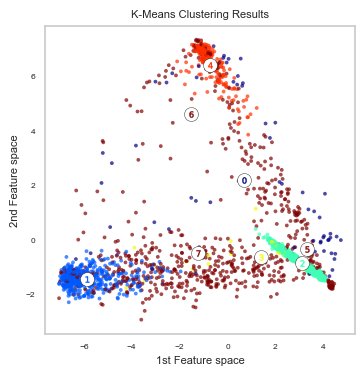

In [800]:
fig, ax = plt.subplots(figsize=(4, 4))
create_cluster_plot(labels, 7, X_pca, gmm, ax, 'gmm')

In [801]:
print(f'silhouette euclidean for n_components 8 and n_init 15: {calculate_silhouette_score(X_pca, labels, 'euclidean', 'gmm')}')
print(f'silhouette cosine for n_components 8 and n_init 15: {calculate_silhouette_score(X_pca, labels, 'cosine', 'gmm')}')

silhouette euclidean for n_components 8 and n_init 15: 0.4272002574785839
silhouette cosine for n_components 8 and n_init 15: 0.4476611474451548
